In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('dark_background')


In [3]:
file = 'C:/Users/Peach/Documents/Dojo-env/dojo-env-setup/DataSets/wines_SPA.csv'

###### Custom Functions

In [4]:
'''
Running this function will loop through all rows in the specified column
and remove ascii characters (excluding decimal points) from values.

The key arguments are:
df: dataframe
col: dataframe column
rep: character that replaces ascii (usually a decimal point)

'''

def clean_cols(df, col, rep):
    
    # Loop through columns within the dataframe for the length of rows in the specified column
    for i in range(len(df[col])):

        # Search for and resub values within the cell respective to the index
        num = re.sub(r'[^0-9\.]+',rep, df[col][i])  
        
        # Assigns new value to the cell of the respective index 
        df[col][i] = float(num)
        
    return df

In [5]:
'''
Running this function will loop through all rows in the specified column and returns
the values that contains an ascii character (excluding decimal points)

'''

def search_cols(df, col):
    
    # Loop through columns within the dataframe for the length of rows in the specified column
    for i in range(len(df[col])):

        # Search for values within the cell respective to the index
        num = re.search(r'[^0-9\.]+', df[col][i])  
        
    return df

In [6]:
'''
This function loops through the dataframe columns and prints the 
data type, column name, and unique elements within the column.

There are three kwargs; 

col allows the user to specify the column of interest,

show_count will toggle the value_counts function, 

sort_values sorts the data in ascending order.

'''

def LU(df, col=None, show_count=False, sort_values=False):

    if col is not None:
        unique_vals = df[col].unique()
        if sort_values:
            unique_vals = sorted(unique_vals) 

        print(col,
              '\n',
              df[col].dtype,
              '\n\n',
              unique_vals,
              '\n',
              df[col].value_counts() if show_count else "",
              '\n'
              )
    else:
        for i in df.columns:
            unique_vals = df[i].unique()
            if sort_values:
                unique_vals = sorted(unique_vals)

            print(i,
                  '\n',
                  df[i].dtype,
                  '\n\n',
                  unique_vals,
                  '\n',
                  df[i].value_counts() if show_count else "",
                  '\n'
                  )

# Explore Dataset

In [7]:
df = pd.read_csv(file)

In [8]:
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


# Cleaning Wine Sales

In [9]:
LU(df)

winery 
 object 

 ['Teso La Monja' 'Artadi' 'Vega Sicilia' 'Pago de Carraovejas'
 'Toro Albala' 'Bodegas El Nido' 'Valdespino' 'Dominio de Pingus'
 'Alvaro Palacios' 'Ordonez' 'Bodegas Valduero' 'Vina Sastre'
 'Sierra Cantabria' 'Descendientes de J. Palacios' 'La Rioja Alta'
 'Marques de Murrieta' 'Vinedos de Paganos' 'Emilio Moro'
 'Quinta de la Quietud' 'Bodegas Mauro' 'Bodega Contador (Benjamin Romeo)'
 'Remirez de Ganuza' 'Bodegas San Roman' 'Pago de Los Capellanes'
 'Bodega Numanthia' 'Alto Moncayo' 'Mas Doix' 'Finca Moncloa'
 'Bodegas Roda' 'Martinet' 'Recaredo' 'Clos Erasmus' 'Barbadillo'
 'Gonzalez-Byass' 'Bodegas Amaren' 'Alvear' 'Equipo Navazos' 'Morca'
 'Territorio Luthier' 'Rafael Palacios' 'Terra Remota'
 'Dehesa de Los Canonigos' 'Miguel Merino' 'Gutierrez de la Vega' 'Alion'
 'Aalto' 'Carmelo Rodero' 'Dominio del Bendito' "Mas d'en Gil"
 'Casa Castillo' 'Matarromera' 'Nin-Ortiz' 'Vinas del Vero'
 'Marques de Riscal' 'Arzuaga' 'Bodegas Mas Alta' 'Dominio de Calogia'
 'To

## The column country only consists of one item. This column can be dropped.

In [10]:
df.drop('country', axis=1, inplace= True)

# Address inconsitencies per column

In [11]:
# Looping through columns so I can identify missing data, which column they belong to, and data type of the column.

for col in df:
  print(col, df[col].isna().sum(), df[col].dtypes)

winery 0 object
wine 0 object
year 2 object
rating 0 float64
num_reviews 0 int64
region 0 object
price 0 float64
type 545 object
body 1169 float64
acidity 1169 float64


The missing values in the object type columns can be imputed after splitting using one hot encoder or ordinal encoding. Missing values in float64 type columns can be imputed now. These types of columns describe teirs/ordinal values and can be reasonably assumed.

In [12]:
# Lets start with body

LU(df, 'body')

body 
 float64 

 [ 5.  4.  3. nan  2.] 
  



In [13]:
# It can be assumed that the missing value is '1'

df['body'].fillna(1, inplace= True)

LU(df, 'body')

body 
 float64 

 [5. 4. 3. 1. 2.] 
  



In [14]:
# Then we can convert it to an int64

df['body'] = df['body'].astype('int64')

LU(df, 'body')

body 
 int64 

 [5 4 3 1 2] 
  



In [15]:
# Next is 'acidity'
# I can be assumed that acidity is refering to the pH value of wine. This rating goes from 2.5 to 4.5

LU(df, 'acidity')

acidity 
 float64 

 [ 3.  2.  1. nan] 
  



In [16]:
# However, these values are clearly ordinal numbers. So we can assume that the missing value would be 4.

df['acidity'].fillna(4, inplace= True)

In [17]:
# Then we can convert it to an int64

df['acidity'] = df['acidity'].astype('int64')

In [18]:
LU(df, 'acidity')

acidity 
 int64 

 [3 2 1 4] 
  



[wine acidity reference](https://winefolly.com/deep-dive/understanding-acidity-in-wine/)

In [19]:
# Lets explore the 'year' column. There is incongruent data that can probably be reasonbly be imputed.

LU(df, 'year')

year 
 object 

 ['2013' '2018' '2009' '1999' '1996' '1998' '2010' '1995' '2015' '2011'
 '2016' '1970' '1946' '1962' '2019' '2004' 'N.V.' '1931' '1979' '2005'
 '2020' '2014' '1985' '1929' '2007' '2012' '2017' '2008' nan '2006' '2000'
 '2003' '2002' '1991' '1994' '1990' '1989' '1987' '1986' '1981' '2001'
 '1968' '1964' '1982' '1974' '1983' '1955' '1980' '1972' '1953' '1958'
 '1942' '1965' '1992' '1973' '1997' '1967' '1975' '1910' '1961' '1954'
 '1988' '1969' '1951' '1928' '1976' '1949' '2021' '1959' '1922' '1978'
 '1925'] 
  



In [20]:
df.dropna(inplace=True)

In [21]:
ratings  = [4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2]

bins = [4.2, 4.4, 4.6, 5]

labels = ['M', 'G', 'O']

df['ratings'] = pd.cut(df['rating'], bins=bins, labels=labels)

In [22]:
df['ratings'].value_counts()

M    1105
G     462
O     154
Name: ratings, dtype: int64

### Drop Duplicates

In [23]:
df.shape

(6953, 11)

In [24]:
# Count amount of duplicated rows

df.duplicated().sum()

5013

In [25]:
# Drop duplicates 

df.drop_duplicates(inplace=True)

In [26]:
# Ensure duplicates were dropped

df.duplicated().sum()

0

In [27]:
# Check shape of dataframe to ensure it will still be valid

df.shape

(1940, 11)

In [47]:
LU(df,'price',1);

price 
 float64 

 [995.   313.5  324.95 ...  16.76  24.45  31.63] 
 75.000000     16
59.900000     12
95.000000     12
34.900000     11
26.900000     11
              ..
53.700000      1
9.900000       1
40.833333      1
299.286841     1
57.110000      1
Name: price, Length: 1241, dtype: int64 



# Visualizations

<AxesSubplot: >

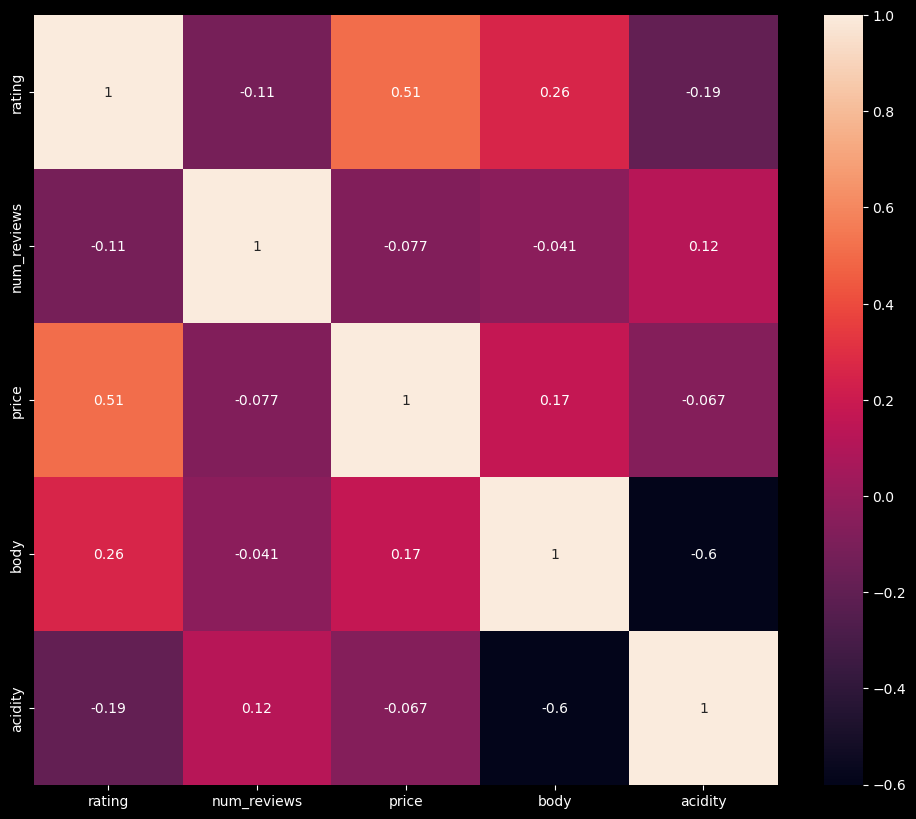

In [29]:
dfcorr = df.corr()
plt.subplots(figsize=(12,10))
sns.heatmap(dfcorr, annot=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1940 entries, 0 to 6100
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   winery       1940 non-null   object  
 1   wine         1940 non-null   object  
 2   year         1940 non-null   object  
 3   rating       1940 non-null   float64 
 4   num_reviews  1940 non-null   int64   
 5   region       1940 non-null   object  
 6   price        1940 non-null   float64 
 7   type         1940 non-null   object  
 8   body         1940 non-null   int64   
 9   acidity      1940 non-null   int64   
 10  ratings      1721 non-null   category
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 168.7+ KB


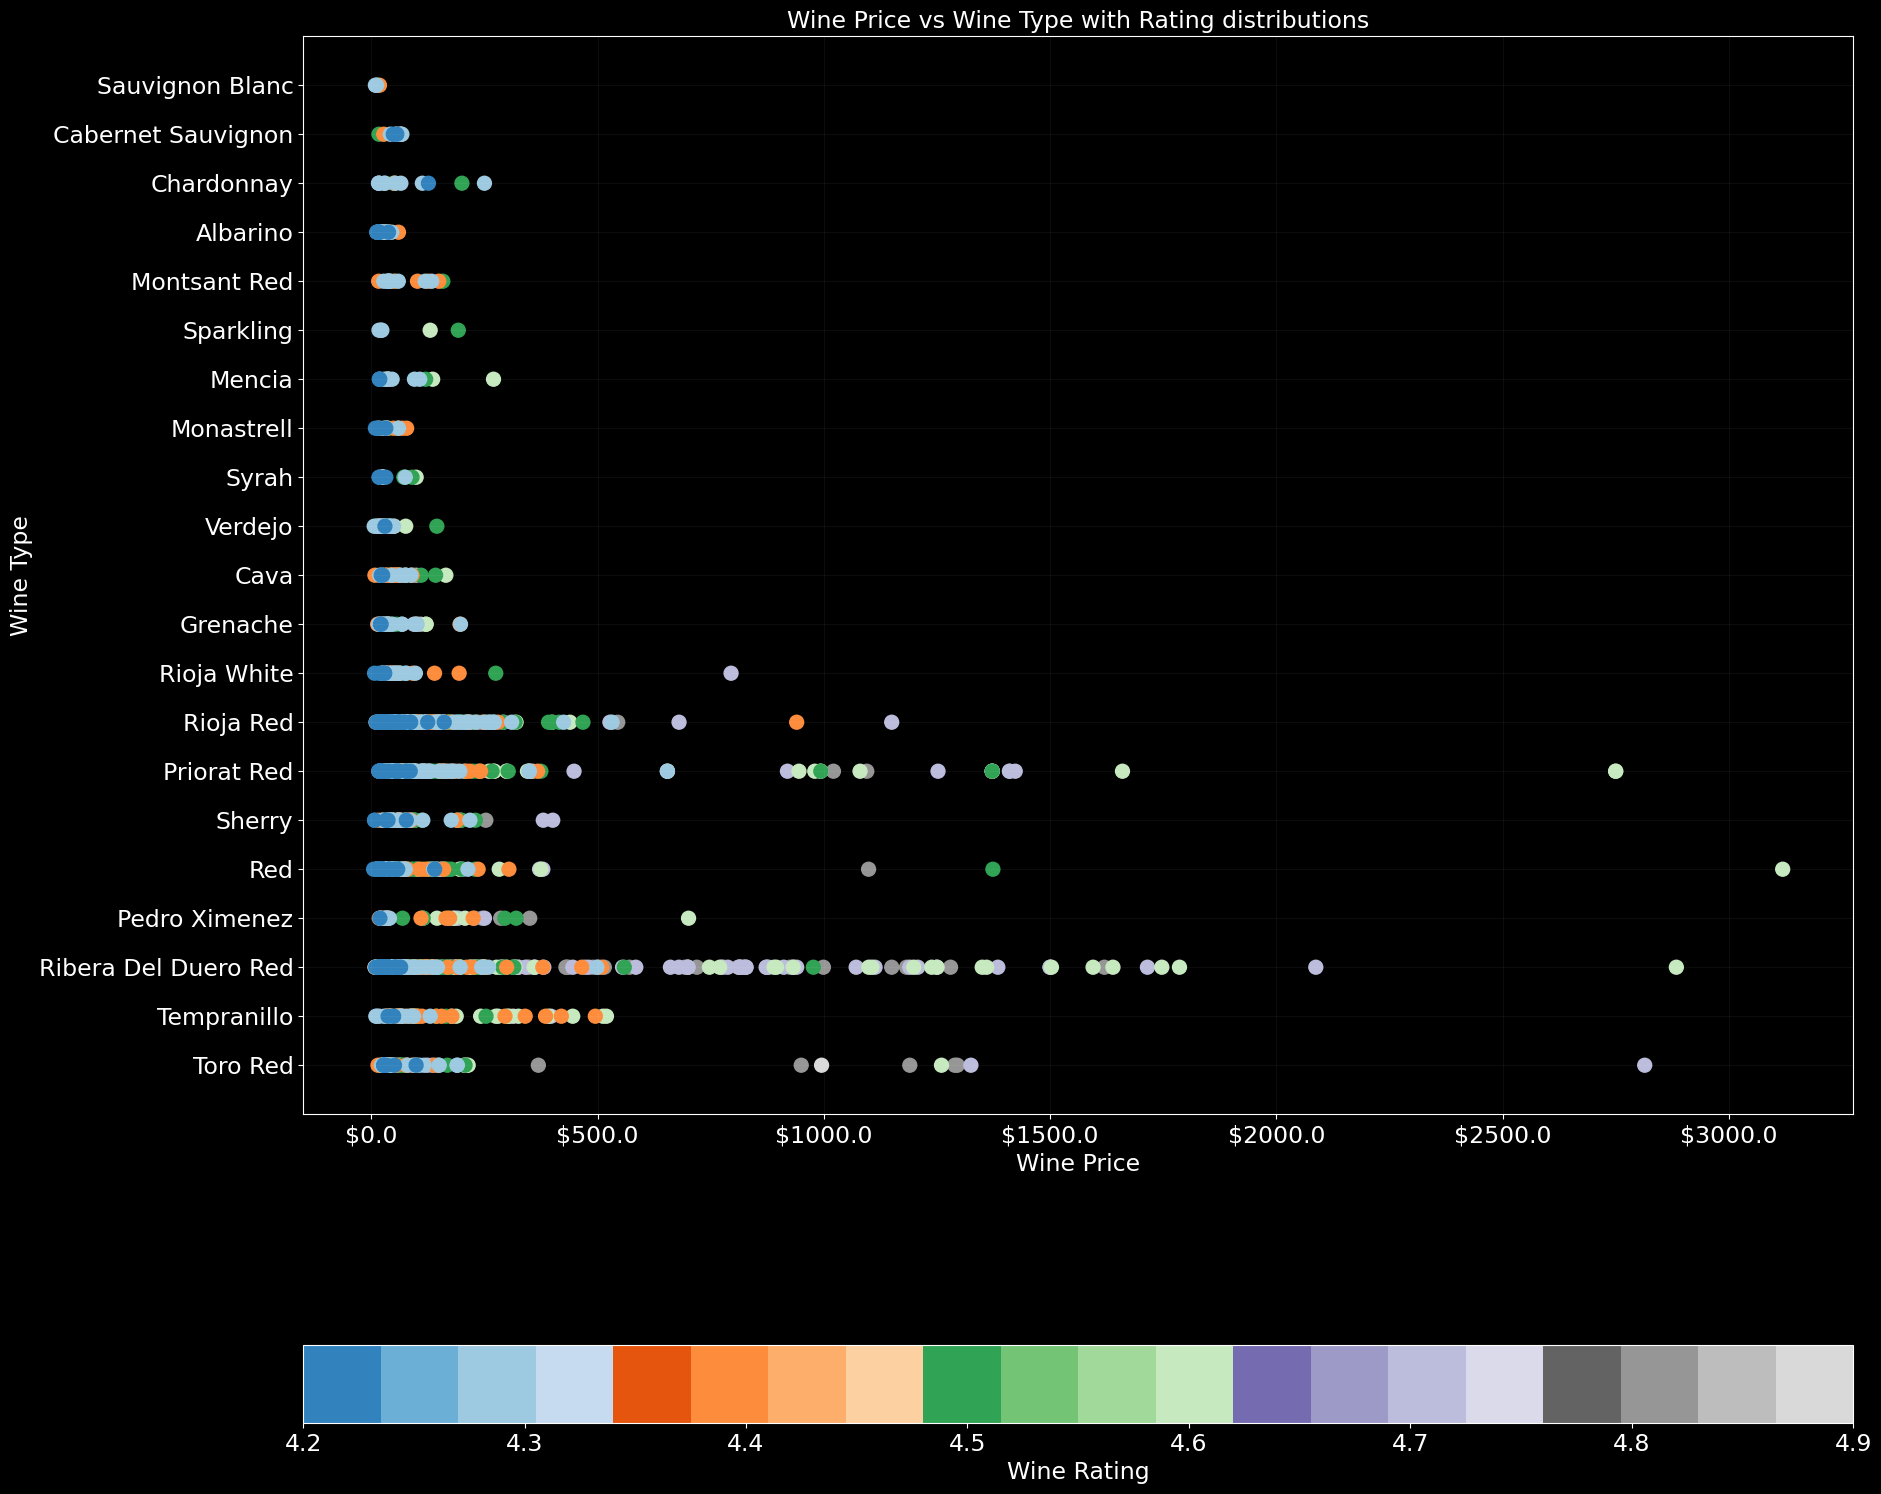

In [99]:
font = 17
def mon_fmt(a,g):
  return f'${a*1e0}'
f,ax = plt.subplots(figsize=(20,20))

c= df['rating']
cmeans = df['price'].mean()
plt.scatter(df['price'], df['type'],c=c, cmap ='tab20c', s=100)

cb = plt.colorbar(orientation='horizontal')
cb.set_label(label = 'Wine Rating',fontsize=font)
cb.ax.tick_params(labelsize=font)

xt, yt = plt.xticks, plt.yticks
xt(fontsize=font)
yt(fontsize=font)

plt.xlabel('Wine Price', fontsize=font)
plt.ylabel('Wine Type', fontsize=font)

ax.xaxis.set_major_formatter(mon_fmt)
ax.set_title('Wine Price vs Wine Type with Rating distributions', fontsize=font)

plt.grid(True, alpha=.05)
plt.show()

## There are noticeable differences in pricing in wines and level of rating as the price increases. Higher rated wines have a notably higher mark up price.

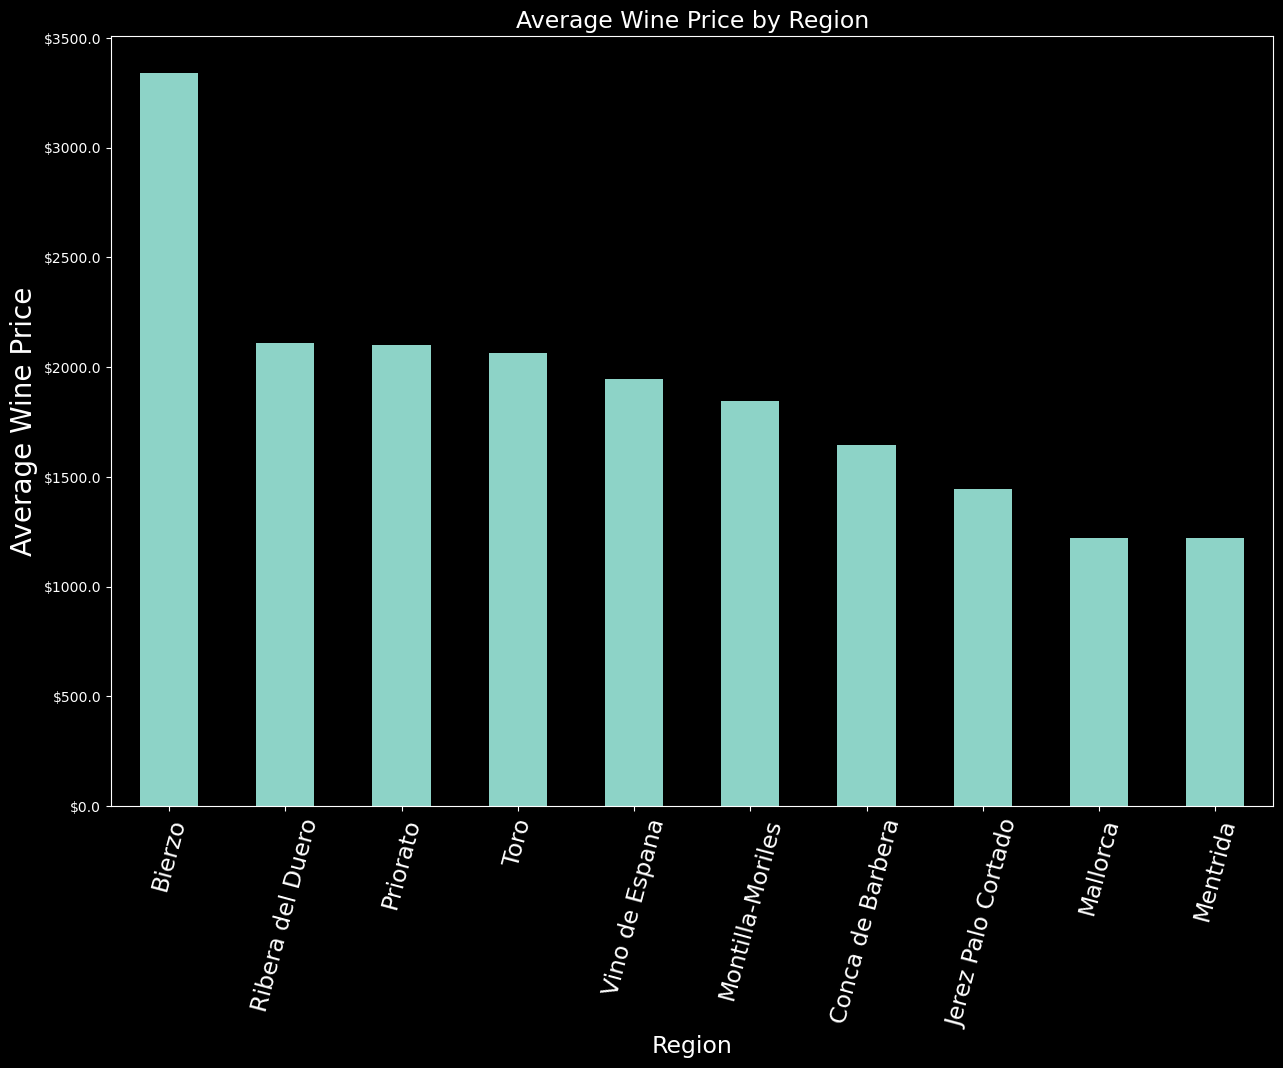

In [155]:
avg_price_by_region = df.groupby('region')['price'].mean().sort_values(ascending=0)

def mon_fmt(a,g):
  return f'${a*1e1}'



# Create a bar plot of the average wine price by region
fig, ax = plt.subplots(figsize=(15, 10))
avg_price_by_region.head(10).plot(kind='bar', y='rating', ax=ax)
# Set the labels and title
ax.set_xlabel('Region', fontsize=font)
ax.set_ylabel('Average Wine Price', fontsize=20)
ax.set_title('Average Wine Price by Region',fontsize=font)
ax.yaxis.set_major_formatter(mon_fmt)

plt.xticks(rotation=75,fontsize=font)
# Show the plot
plt.show()

## Displayed is is the top 10 ordered mean price of wine by region. The left most regions have higher wine prices which offer better investment opportunity.
